In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer

import warnings

# Suppress warnings from GradientBoostingClassifier and VotingClassifier
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.ensemble.gradient_boosting")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.ensemble._voting")

In [2]:
# Load dataset
df = pd.read_csv('../../data/player_game_statistics.csv')

In [3]:
# Inspect the target column
print(df['player_level'].value_counts())

player_level
Novice          1855
Intermediate     603
Expert           111
Name: count, dtype: int64


In [4]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
numerical_columns = df.select_dtypes(include=np.number).columns
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])
# df = df.drop(columns=['player_id', 'game_id'])

# Encode categorical columns
categorical_columns = ['country', 'gender', 'game_name']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Encode target variable
label_encoder = LabelEncoder()
df['churned'] = label_encoder.fit_transform(df['churned'])  # Convert churned to binary
df['player_level'] = label_encoder.fit_transform(df['player_level'])

In [5]:
# Split the dataset
X = df.drop(columns=['player_level','game_id', 'player_id', 'username', 'last_played'])  # Remove non-informative columns
y = df['player_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Normalize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Initialize models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)


#### Hyperparameter Tuning with GridSearchCV

In [8]:
# Hyperparameter Tuning with GridSearchCV
print("Performing Hyperparameter Tuning...")

# Logistic Regression
log_reg_params = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='accuracy')
log_reg_grid.fit(X_train_scaled, y_train)
log_reg = log_reg_grid.best_estimator_

Performing Hyperparameter Tuning...


In [9]:
# Random Forest
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(rf_clf, rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
rf_clf = rf_grid.best_estimator_

In [10]:
# Support Vector Machine
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_grid = GridSearchCV(svm_clf, svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train_scaled, y_train)
svm_clf = svm_grid.best_estimator_

In [11]:
# Gradient Boost(Takes a long to load)
gb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
gb_grid = GridSearchCV(gb_clf, gb_params, cv=5, scoring='accuracy')
gb_grid.fit(X_train, y_train)
gb_clf = gb_grid.best_estimator_

In [12]:
# Ensemble Model (Voting Classifier)
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf', rf_clf),
        ('gb', gb_clf),
        ('svm', svm_clf)
    ],
    voting='soft'  # Soft voting uses predicted probabilities
)
voting_clf.fit(X_train, y_train)
y_pred_ensemble = voting_clf.predict(X_test)

C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Cross-Validation

In [13]:
# Cross-Validation Scores
print("Cross-Validation Scores:")
cv_scores = {
    'Logistic Regression': cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy').mean(),
    'Random Forest': cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy').mean(),
    'SVM': cross_val_score(svm_clf, X_train_scaled, y_train, cv=5, scoring='accuracy').mean(),
    'GBoost': cross_val_score(gb_clf, X_train, y_train, cv=5, scoring='accuracy').mean(),
    'Voting Classifier': cross_val_score(voting_clf, X_train_scaled, y_train, cv=5, scoring='accuracy').mean(),
}

for model, score in cv_scores.items():
    print(f"{model}: {score:.4f}")


Cross-Validation Scores:
Logistic Regression: 0.8876
Random Forest: 0.9664
SVM: 0.8973
GBoost: 0.9659
Voting Classifier: 0.9557


In [14]:
# Predictions
log_reg_pred = log_reg.predict(X_test_scaled)
gb_pred = gb_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
svm_pred = svm_clf.predict(X_test_scaled)
voting_pred = voting_clf.predict(X_test_scaled)

C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [15]:
# Collecting all models' results
models = ['Logistic Regression', 'Gradient Boost', 'SVM', 'Random Forest', 'Voting Classifier']
accuracies = [
    accuracy_score(y_test, log_reg_pred),
    accuracy_score(y_test, gb_pred),
    accuracy_score(y_test, svm_pred),
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, voting_pred)
]

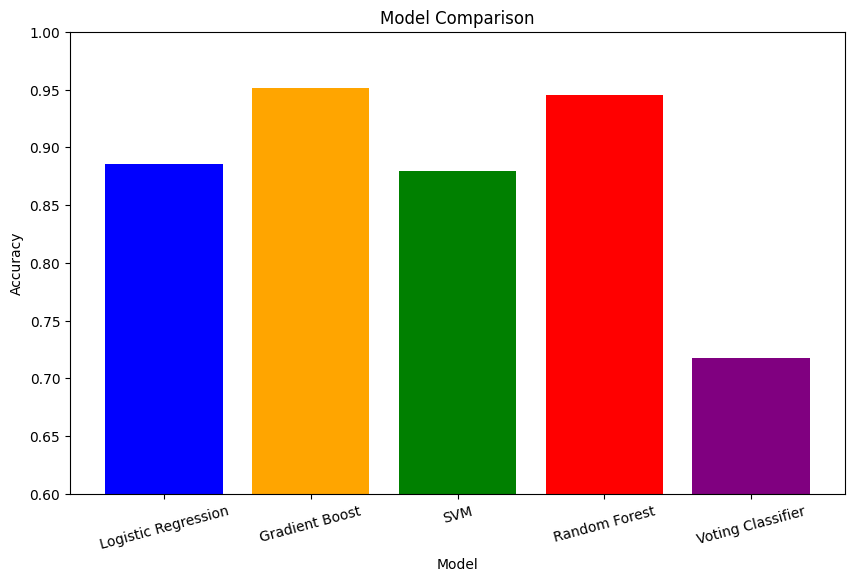

In [16]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0.6, 1.0)  # Adjust as necessary
plt.xticks(rotation=15)
plt.show()

In [17]:
# Evaluate ensemble model
print("Performance of Ensemble Model (Voting Classifier):")
print(classification_report(y_test, y_pred_ensemble))

Performance of Ensemble Model (Voting Classifier):
              precision    recall  f1-score   support

           0       0.73      0.86      0.79        22
           1       0.89      0.89      0.89       123
           2       0.98      0.97      0.98       369

    accuracy                           0.95       514
   macro avg       0.87      0.91      0.89       514
weighted avg       0.95      0.95      0.95       514



In [18]:
# Additional Evaluation using classification reports
print("Logistic Regression Report:\n", classification_report(y_test, log_reg_pred))
print("GBoost Report:\n", classification_report(y_test, gb_pred))
print("SVM Report:\n", classification_report(y_test, svm_pred))
print("Random Forest Report:\n", classification_report(y_test, rf_pred))
print("Voting Classifier Report:\n", classification_report(y_test, voting_pred))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.64      0.73      0.68        22
           1       0.79      0.72      0.75       123
           2       0.93      0.95      0.94       369

    accuracy                           0.89       514
   macro avg       0.79      0.80      0.79       514
weighted avg       0.88      0.89      0.88       514

GBoost Report:
               precision    recall  f1-score   support

           0       0.70      0.73      0.71        22
           1       0.87      0.93      0.90       123
           2       1.00      0.97      0.98       369

    accuracy                           0.95       514
   macro avg       0.85      0.88      0.87       514
weighted avg       0.95      0.95      0.95       514

SVM Report:
               precision    recall  f1-score   support

           0       0.64      0.73      0.68        22
           1       0.74      0.78      0.76       123
           2     

C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [19]:
# Display Cross-Validation Scores
print("\nCross-Validation Scores:")
for model, score in cv_scores.items():
    print(f"{model}: {score:.4f}")


Cross-Validation Scores:
Logistic Regression: 0.8876
Random Forest: 0.9664
SVM: 0.8973
GBoost: 0.9659
Voting Classifier: 0.9557


In [20]:
# Identify the best-performing model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.2f}")

Ensemble Model Accuracy: 0.95


In [21]:
# After training, save the model and scaler
# joblib.dump(xgb_clf, 'xgb_model.joblib')
# joblib.dump(scaler, 'scaler.joblib')